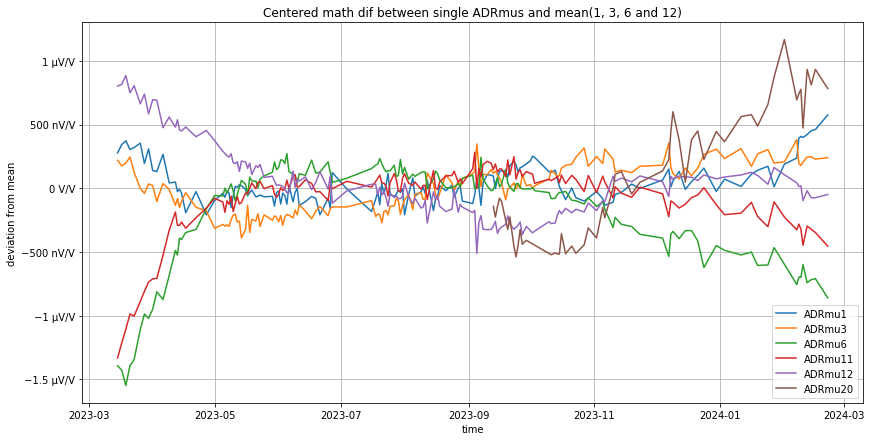

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter


def MUvsMEAN(dut, ref_group, dmm):
    
    # Fetch data
    url = "https://raw.githubusercontent.com/marcoreps/multiinstrumentalist/master/csv/"
    columns = ["Time", dmm]
    dataframes = [pd.read_csv(url+ref+"-"+dmm+".csv", usecols=columns) for ref in ref_group]
    dataframes.append(pd.read_csv(url+dut+"-"+dmm+".csv", usecols=columns))

    for i in range(len(dataframes)):
        
        dataframes[i] = dataframes[i].rename(columns={"3458A": i})
        
        # Use datetime as index
        dataframes[i]["Time"] = pd.to_datetime(dataframes[i]["Time"], unit='ms')
        dataframes[i] = dataframes[i].set_index(pd.DatetimeIndex(dataframes[i]["Time"]))
        #dataframes[i] = dataframes[i].drop('Time', axis=1)
        
        # Resample to one daily value
        dataframes[i] = dataframes[i].resample("d").mean()
        
    daily_dut = dataframes.pop()
    daily_mean = dataframes.pop(0)
    
    # Prepare daily averages of ref_group
    for df in dataframes:
        daily_mean = daily_mean.join(df, on="Time")
    # Drop days where no data was found
    daily_mean = daily_mean.dropna()
    daily_mean = daily_mean.mean(axis=1)
    
    # Result is the difference between DUT and average of ref_group
    result = daily_dut.subtract(daily_mean, axis=0).dropna()
    # Scale values for later display of µV/V or ppm of 10V
    result = result / 10
    # Remove "DC" from result
    result = result - result.median()
    
    return result
    

# Set up a plot
plt.rcParams["figure.figsize"] = [14, 7]
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='time', title="Centered math dif between single ADRmus and mean(1, 3, 6 and 12)")
ax.set_ylabel('deviation from mean')
ax.yaxis.set_major_formatter(EngFormatter(unit='V/V'))


ref_group = ["ADRmu1", "ADRmu3", "ADRmu12", "ADRmu6", ]
dmm = "3458A"

ADRmu1 = MUvsMEAN("ADRmu1", ref_group, dmm)
ADRmu3 = MUvsMEAN("ADRmu3", ref_group, dmm)
ADRmu6 = MUvsMEAN("ADRmu6", ref_group, dmm)
#ADRmu9 = MUvsMEAN("ADRmu9", ref_group, dmm)
ADRmu11 = MUvsMEAN("ADRmu11", ref_group, dmm)
ADRmu12 = MUvsMEAN("ADRmu12", ref_group, dmm)
#ADRmu15 = MUvsMEAN("ADRmu15", ref_group, dmm)
ADRmu20 = MUvsMEAN("ADRmu20", ref_group, dmm)

ax.plot(ADRmu1, label='ADRmu1')
ax.plot(ADRmu3, label='ADRmu3')
ax.plot(ADRmu6, label='ADRmu6')
#ax.plot(ADRmu9, label='ADRmu9')
ax.plot(ADRmu11, label='ADRmu11')
ax.plot(ADRmu12, label='ADRmu12')
#ax.plot(ADRmu15, label='ADRmu15')
ax.plot(ADRmu20, label='ADRmu20')

ax.legend()
plt.show()